<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_EPI_2D_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pypulseq &> /dev/null
!pip install  torchkbnufft --no-deps
!pip install MRzeroCore --no-deps
!pip install pydisseqt
!pip install ismrmrd

!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

In [1]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100


(EPI_2D_seq)=
# 2D EPI

In [ ]:
def seq_EPI_2D(
    fov=(220e-3, 220e-3, 8e-3),
    Nread=64,
    Nphase=64,
    Npart=1,
    FA=torch.tensor(90 * np.pi / 180),
    slice_thickness=8e-3,
    experiment_id='EPI_2D',
    system=None,
    # EPI-specific parameters
    rf_duration=1e-3,
    rf_apodization=0.5,
    rf_time_bw_product=4,
    adc_duration_OG=0.25e-3,
    eddy_currents=True,
    eddy_currents_induced_delay=0.0000015,
    blip_duration=0.1e-3
):
    """
    2D EPI sequence function following MRzero standard.
    
    Args:
        fov: tuple of floats (x, y, z) in meters
        Nread: int - frequency encoding steps
        Nphase: int - phase encoding steps
        Npart: int - number of partitions
        FA: tensor - flip angle
        slice_thickness: float - slice thickness
        experiment_id: string - experiment identifier
        system: optional scanner system limits
        rf_duration: float - RF pulse duration
        rf_apodization: float - RF apodization
        rf_time_bw_product: float - RF time-bandwidth product
        adc_duration_OG: float - ADC duration
        eddy_currents: bool - enable eddy current compensation
        eddy_currents_induced_delay: float - eddy current delay
        blip_duration: float - blip gradient duration
    
    Returns:
        pp.Sequence: PyPulseq sequence object
    """
    # Choose the scanner limits
    if system is None:
        system = pp.Opts(
            max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
            rf_ringdown_time=20e-6, rf_dead_time=100e-6,
            adc_dead_time=20e-6, grad_raster_time=10e-6
        )

    # Define the sequence
    seq = pp.Sequence()

    # Define RF events
    rf1, _, _ = pp.make_sinc_pulse(
        flip_angle=FA.item(), duration=rf_duration,
        slice_thickness=slice_thickness, apodization=rf_apodization, 
        time_bw_product=rf_time_bw_product, system=system, return_gz=True
    )

    # Define other gradients and ADC events
    a = int(system.adc_raster_time * Nread * 10**7)
    b = int(system.grad_raster_time * 10**7)
    c = int(adc_duration_OG * 10**7)
    lcm_ab = abs(a * b) // np.gcd(a, b)
    adc_raster_duration = (lcm_ab if round(c / lcm_ab) == 0 else round(c / lcm_ab) * lcm_ab) / 10**7

    eddy_currents_induced_delay *= eddy_currents

    gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov[0], flat_time=adc_raster_duration, system=system)
    gx_ = pp.make_trapezoid(channel='x', flat_area=-Nread / fov[0], flat_time=adc_raster_duration, system=system)
    adc = pp.make_adc(num_samples=Nread, duration=adc_raster_duration, phase_offset=0 * np.pi / 180, 
                     delay=gx.rise_time + eddy_currents_induced_delay, system=system)
    gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)

    # Construct sequence
    gp_blip = pp.make_trapezoid(channel='y', area=1 / fov[1], duration=blip_duration, system=system)

    seq.add_block(rf1)
    gp = pp.make_trapezoid(channel='y', area=-Nphase//2 / fov[1], duration=1e-3, system=system)
    seq.add_block(gx_pre, gp)

    for ii in range(0, Nphase//2):
        seq.add_block(gx, adc)
        seq.add_block(gp_blip)
        seq.add_block(gx_, adc)
        seq.add_block(gp_blip)
    
    # Required sequence definitions
    seq.set_definition('name', experiment_id)
    seq.set_definition('fov', [fov[0], fov[1], fov[2]])
    seq.set_definition('matrix', [Nread, Nphase, Npart])
    
    return seq


C:\Users\alyar\AppData\Local\Temp\ipykernel_2852\2029941968.py:54: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf1, _, _ = pp.make_sinc_pulse(
C:\Users\alyar\github\MRzero-Core\python\MRzeroCore\util.py:788: UserWarning: write(): 64 timing errors found in the sequence
  seq.write("tmp.seq")


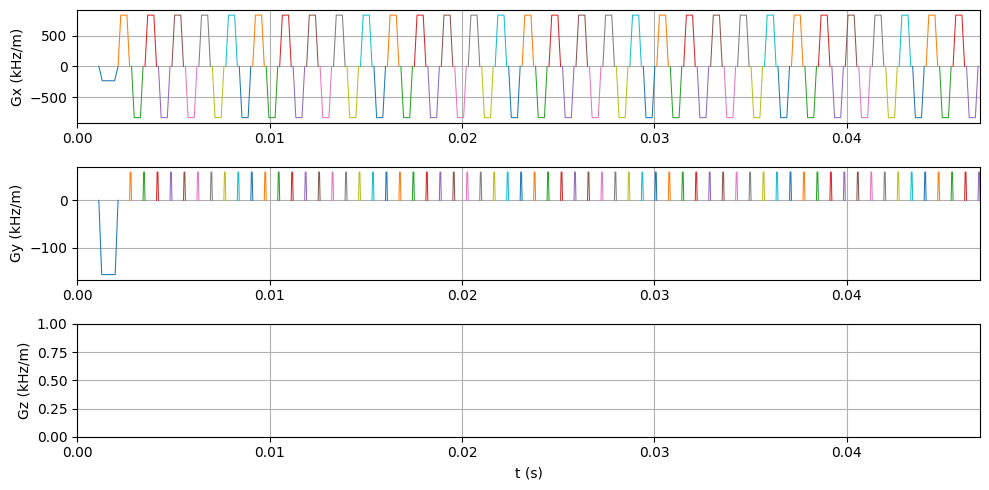

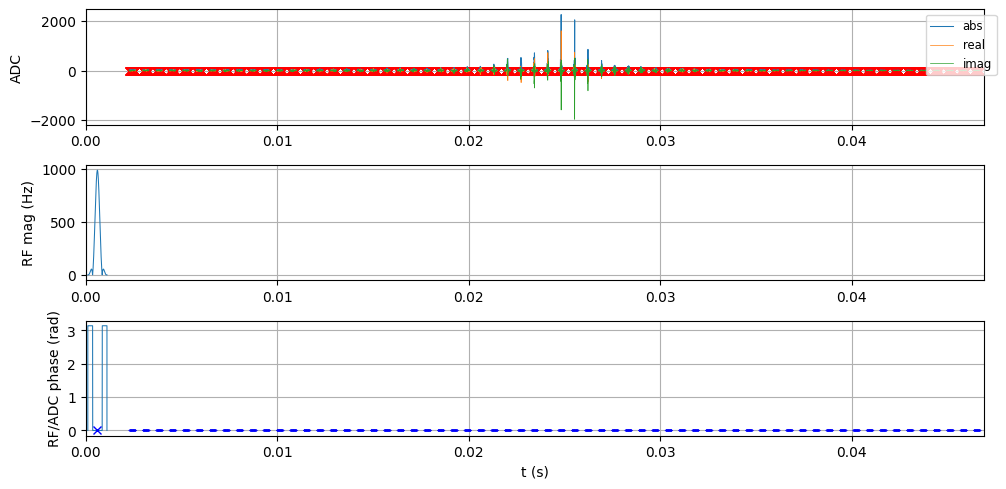

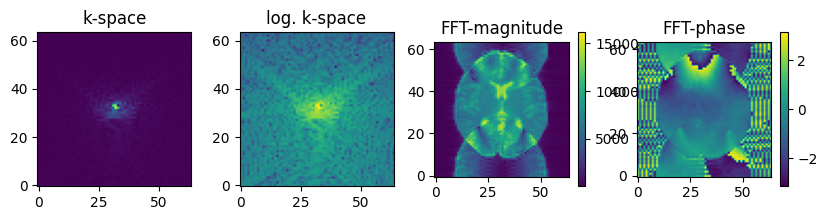

In [3]:
# Define parameters as plain variables
experiment_id = 'EPI_2D'
fov = 240e-3 # @param {type:"number"} # Define FOV
slice_thickness = 8e-3
Nread = 64  # @param {type:"integer"} # frequency encoding steps/samples
Nphase = 64 # @param {type:"integer"} # phase encoding steps/samples
Npart = 1
FA = torch.tensor(90 * np.pi / 180)
slice_thickness = 8e-3

# EPI-specific parameters
rf_duration = 1e-3
rf_apodization = 0.5
rf_time_bw_product = 4
adc_duration_OG = 0.25e-3  # @param {type: "slider", min: 0.25e-3, max: 10e-3, step: 0.05e-3} # Moved to function parameters
eddy_currents = True       # @param {type:"boolean"}
eddy_currents_induced_delay = 0.0000015 # @param {type: "slider", min: -1e-4, max: 1e-4, step: 1e-8} # Moved to function parameters
blip_duration = 0.1e-3

# Generate sequence using standard parameters
seq = seq_EPI_2D(
    fov=(fov, fov, slice_thickness),
    Nread=Nread,
    Nphase=Nphase,
    Npart=Npart,
    FA=FA,
    slice_thickness=slice_thickness,
    experiment_id=experiment_id,
    rf_duration=rf_duration,
    rf_apodization=rf_apodization,
    rf_time_bw_product=rf_time_bw_product,
    adc_duration_OG=adc_duration_OG,
    eddy_currents=eddy_currents,
    eddy_currents_induced_delay=eddy_currents_induced_delay,
    blip_duration=blip_duration
)

# Quick simulation and plot
signal, _ = mr0.util.simulate(seq)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal=signal.numpy())
plt.show()

# MR IMAGE RECONSTRUCTION
fig = plt.figure(figsize=(10, 2))

kspace_adc = torch.reshape(signal, (Nphase, Nread)).clone().t()
kspace = kspace_adc
kspace[:, 0::2] = torch.flip(kspace[:, 0::2], [0])[:, :]

# fftshift FFT fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(141)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(142)
plt.title('log. k-space')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(143)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(144)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()


In [4]:
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# Prepare the sequence output for the scanner
seq_write_signature = seq.write(experiment_id + '.seq')

Timing check failed. Error listing follows:
namespace(block=3, event='adc', field='delay', value=0.00014150000000000002, value_rounded=0.00014199999999999998, error=-4.999999999999579e-07, raster='rf_raster_time', error_type='RASTER')
namespace(block=5, event='adc', field='delay', value=0.00014150000000000002, value_rounded=0.00014199999999999998, error=-4.999999999999579e-07, raster='rf_raster_time', error_type='RASTER')
namespace(block=7, event='adc', field='delay', value=0.00014150000000000002, value_rounded=0.00014199999999999998, error=-4.999999999999579e-07, raster='rf_raster_time', error_type='RASTER')
namespace(block=9, event='adc', field='delay', value=0.00014150000000000002, value_rounded=0.00014199999999999998, error=-4.999999999999579e-07, raster='rf_raster_time', error_type='RASTER')
namespace(block=11, event='adc', field='delay', value=0.00014150000000000002, value_rounded=0.00014199999999999998, error=-4.999999999999579e-07, raster='rf_raster_time', error_type='RASTER')


C:\Users\alyar\AppData\Local\Temp\ipykernel_2852\729143520.py:10: UserWarning: write(): 64 timing errors found in the sequence
  seq_write_signature = seq.write(experiment_id + '.seq')


# Phantom changes

If you alter phantom parameters between

```
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
```
and
```
obj_p = obj_p.build()
```

you can alter the object manually to study phase images or distortions.

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


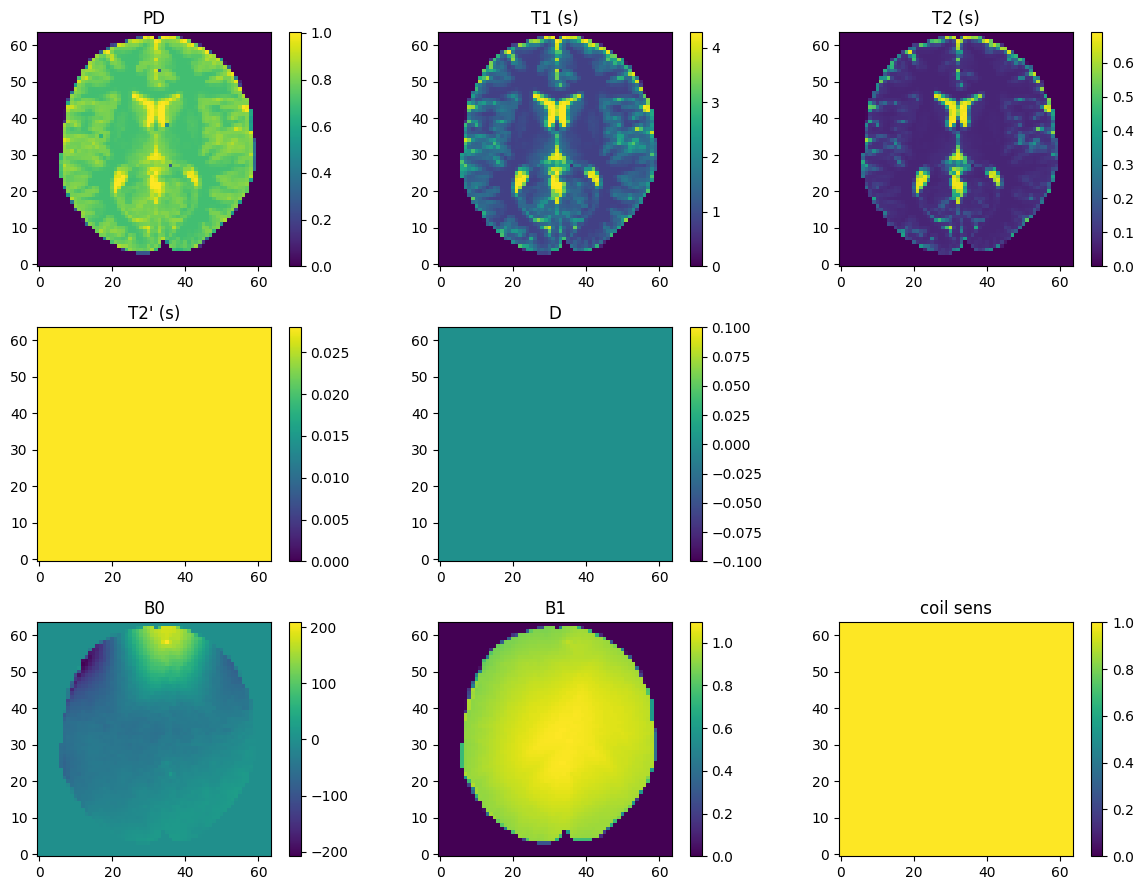

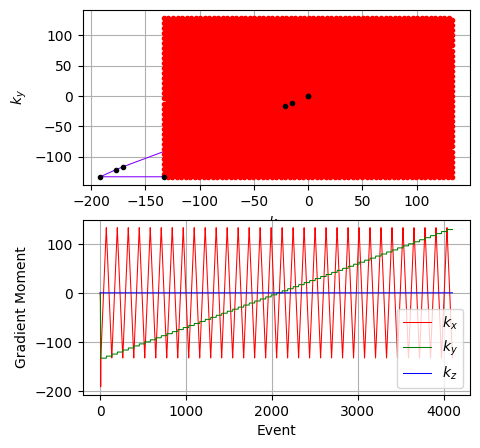

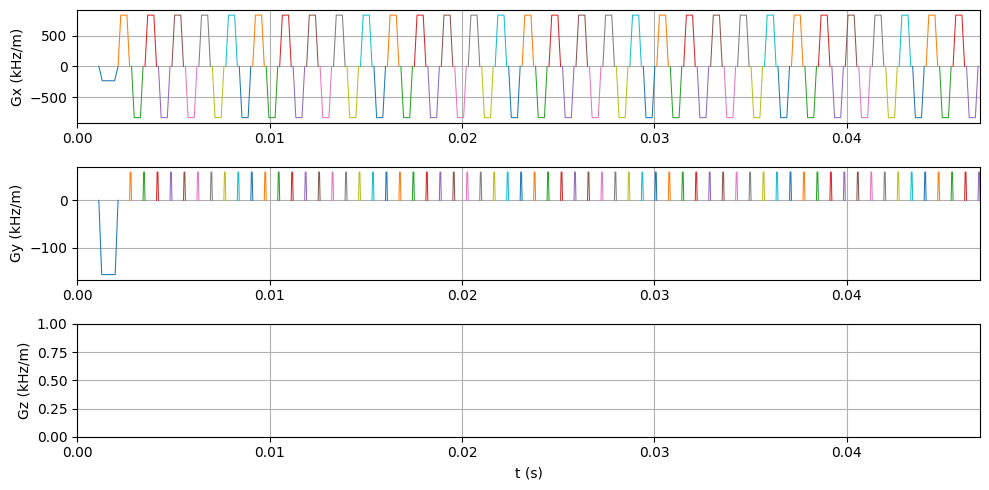

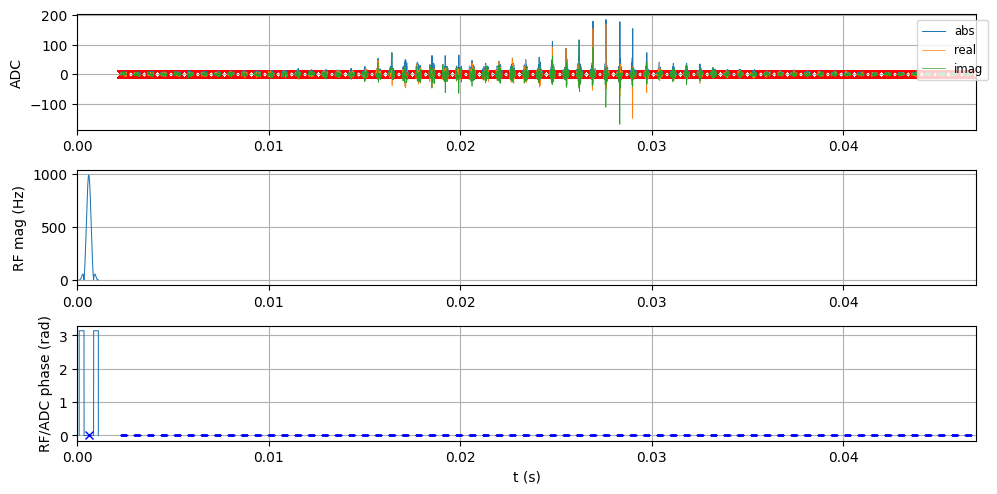

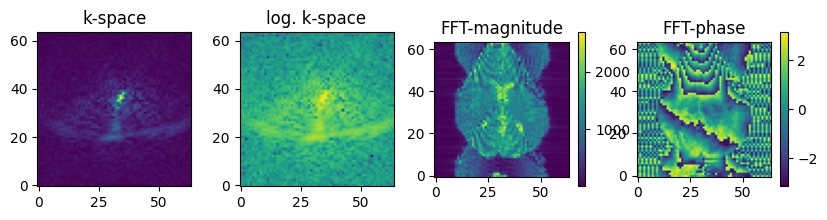

In [5]:
# Phantom simulation with brain phantom
sz = [64, 64]

# Load phantom object from file
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)

# Manipulate loaded data
obj_p.D *= 0
T2dash = 0.028001# @param {type: "slider", min: 1e-6, max: 100e-3, step:1e-3}
obj_p.T2dash[:] = T2dash
B0factor = 5# @param {type: "slider", min: -20, max: 20, step:1}
obj_p.B0 *= B0factor    # alter the B0 inhomogeneity

obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()

# Simulate the sequence
seq0 = mr0.Sequence.import_file(experiment_id + '.seq')
seq0.plot_kspace_trajectory()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)

# PLOT sequence with signal in the ADC subplot
plt.close(11)
plt.close(12)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal=signal.numpy())
plt.show()

# MR IMAGE RECONSTRUCTION
fig = plt.figure(figsize=(10, 2))

kspace_adc = torch.reshape(signal, (Nphase, Nread)).clone().t()
kspace = kspace_adc
kspace[:, 0::2] = torch.flip(kspace[:, 0::2], [0])[:, :]

# fftshift FFT fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(141)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(142)
plt.title('log. k-space')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(143)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(144)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()